In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import random
import matplotlib.pyplot as plt

TEST_SET_THRESHOLD = 20
TEST_SET_HOLDOUT = 0.2

In [14]:
tracks = pd.read_csv('../input/tracks.csv')
train = pd.read_csv('../input/train.csv')
target = pd.read_csv('../input/target_playlists.csv')

# SPLITTING DATASET

In [137]:
#Raggruppiamo per playlist_id, le celle conterranno il count() del gruppo, quindi il numero di canzoni per playlist
grouped = train.groupby('playlist_id')['track_id'].nunique()

#Prendiamo le playlist che superano il numero di elementi del TEST_SET_THRESHOLD
clipped = grouped.index[grouped>TEST_SET_THRESHOLD].tolist()

#Adesso prendiamo a caso degli indici di playlist in percentuale di TEST_SET_HOLDOUT
#ATTENZIONE, la percentuale viene calcolata sulla lunghezza di clipped, che avrà un numero di elementi inferiore a train
#Questo significa che il 20% di clipped sarà circa il 14% del train, la percentuale è da aggiustare tenendo conto di sto fatto
test_set_indices = [ clipped[i] for i in sorted(random.sample(range(len(clipped)), int(TEST_SET_HOLDOUT*len(clipped)))) ]

#Andiamo a estrarre dal train TUTTE le canzoni delle playlist estratte a sorte nella riga prima
test_groups = train.loc[train['playlist_id'].isin(test_set_indices)]

#Andiamo a creare un dataframe vuoto, a cui appenderemo tutte le canzoni da ficcare nel test_set con una .append()
test_set = pd.DataFrame(columns=["playlist_id","track_id"])

#Per ogni gruppo prendiamo le ultime 10 canzoni e le appendiamo al test_set
for name, group in test_groups.groupby('playlist_id'):
    test_set = test_set.append(group.tail(10))
    
#Togliamo le canzoni del test set al train, salvandolo in una nuova variabile 
#Questo è solo un trick per fare la differenza insiemistica
training_set = pd.concat([train, test_set, test_set]).drop_duplicates(keep=False)


KeyboardInterrupt: 

In [10]:
def build_urm(data):
    fill_data = np.ones(data.shape[0])
    #posso usare gli id direttamente solo perchè come già detto sono consistenti
    row = data['playlist_id'].values
    col = data['track_id'].values
    n_pl = data['playlist_id'].nunique()
    n_tr = data['track_id'].nunique()
    return sparse.coo_matrix((fill_data, (row, col)), dtype=np.int32, shape=(n_pl, n_tr))

def build_tracks_lil(data):
    albums_id = data['album_id']
    artists_id = data['artist_id']
    durations = data['duration_sec']
    tracks = data['track_id']
    
    albums_max = np.amax(albums_id)
    artists_max = np.amax(artists_id)
    durations_max = np.amax(durations)
    number_of_songs = data.shape[0]
    
    icm_lil_matrix = sparse.lil_matrix((number_of_songs, albums_max + artists_max + durations_max + 3))
    
    icm_lil_matrix[tracks,albums_id] = 1
    icm_lil_matrix[tracks, albums_max + artists_id] = 1
    icm_lil_matrix[tracks, albums_max + artists_max + durations] = 1
    
    return icm_lil_matrix

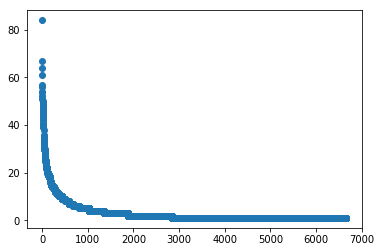

In [25]:
artists = tracks['artist_id'].value_counts()
plt.scatter(range(artists.size), artists)
plt.show()

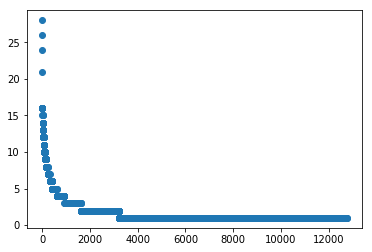

In [27]:
albums = tracks['album_id'].value_counts()
plt.scatter(range(albums.size), albums)
plt.show()

In [7]:
def classify_durations(data):
    data.loc[tracks['duration_sec'].isin(range(60)),'duration_sec'] = 1
    data.loc[tracks['duration_sec'].isin(range(60,120)), 'duration_sec'] = 2
    data.loc[tracks['duration_sec'].isin(range(120,180)), 'duration_sec'] = 3
    data.loc[tracks['duration_sec'].isin(range(180,240)), 'duration_sec'] = 4
    data.loc[tracks['duration_sec'].isin(range(240,300)), 'duration_sec'] = 5
    data.loc[tracks['duration_sec'].isin(range(300,200000)), 'duration_sec'] = 6

    data['duration_sec'].value_counts()



# Building URM

In [4]:
urm = build_urm(train)
urm.count_nonzero() == len(train)

# Building track lil matrix

In [15]:
classify_durations(tracks)
lil = build_tracks_lil(tracks)

In [16]:
lil

<20635x19419 sparse matrix of type '<class 'numpy.float64'>'
	with 61905 stored elements in LInked List format>

In [17]:
tracks.shape

(20635, 4)